# Hyper-parameter Search with Bayesian Optimisation (skopt)

The purpose of the kernel is to demonstrate how to find an optimal set of hyper-parameters for the RNN models that suit to our problem. 


## UPDATE:

- v.1-6: Model architecture: Bi-GRU/Bi-LSTM --> hyperparams: spatial dropout, GRU/LSTM dropouts, embedding dim

- v.7: Add learning rate as hyperparameter, change loss to custom

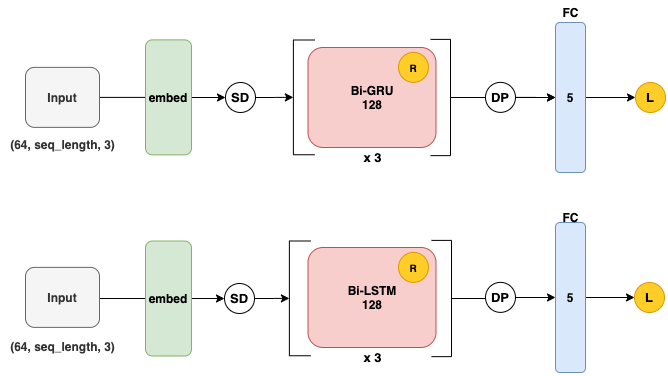

# Imports & Helpers

NOTE: make sure you downgrade sklearn (due to compatibility issues)

In [ ]:
# !pip install ../input/my-wheels/scikit_learn-0.21.0-cp37-cp37m-manylinux1_x86_64.whl

! pip install scikit_learn==0.21.0

In [ ]:
import numpy as np
import pandas as pd 
from tqdm.notebook import tqdm
import os
import gc
import skopt
import random

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import *
from skopt.utils import use_named_args

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

import sklearn
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import mean_squared_error

print(skopt.__version__, sklearn.__version__)

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed=42)

In [ ]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def preprocess_char_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

In [ ]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def rmse_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
    
def rmse_metric(y_true, y_pred):
    metrics = []
    
    y_pred_flat = y_pred.reshape(-1, 5)
    y_true_flat = y_true.reshape(-1, 5)
        
    for _target in range(len(target_cols)):
        metrics.append(rmse_2(y_true_flat[:, _target], y_pred_flat[:, _target]))
    
    return np.mean(metrics)


def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)


# label_encoding
def label_encode(train_data, test_data):
    
    sequence_encmap = {'A': 0, 'G' : 1, 'C' : 2, 'U' : 3}
    structure_encmap = {'.' : 0, '(' : 1, ')' : 2}
    looptype_encmap = {'S':0, 'E':1, 'H':2, 'I':3, 'X':4, 'M':5, 'B':6}

    enc_targets = ['sequence', 'structure', 'predicted_loop_type']
    enc_maps = [sequence_encmap, structure_encmap, looptype_encmap]

    for t,m in zip(enc_targets, enc_maps):
        for c in [c for c in train_data.columns if t in c]:
            train_data[c] = train_data[c].replace(m)
            test_data[c] = test_data[c].replace(m)
    return train_data, test_data

In [ ]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
target_scored = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

# Config

In [ ]:
FILTER_SNR = True
N_TRIALS = 15
SEED = 34          # 2020

# Load data

In [ ]:
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_df = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')

In [ ]:
if FILTER_SNR:
    train = train[train.signal_to_noise > 1]


train_inputs = preprocess_char_inputs(train)
train_labels = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))

print(train_inputs.shape, train_labels.shape)

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, test_size=0.1, random_state=34)

print('training/validation shapes:', train_inputs.shape, val_inputs.shape)

# Use Bayesian Optimization for Hyper-parameter search

The idea with Bayesian optimization is to construct another model of the search-space for hyper-parameters. One kind of model is known as a Gaussian Process. This gives us an estimate of how the performance varies with changes to the hyper-parameters. Whenever we evaluate the actual performance for a set of hyper-parameters, we know for a fact what the performance is - except perhaps for some noise. We can then ask the Bayesian optimizer to give us a new suggestion for hyper-parameters in a region of the search-space that we haven't explored yet, or hyper-parameters that the Bayesian optimizer thinks will bring us most improvement. We then repeat this process a number of times until the Bayesian optimizer has built a good model of how the performance varies with different hyper-parameters, so we can choose the best parameters.

The flowchart of the algorithm is roughly:

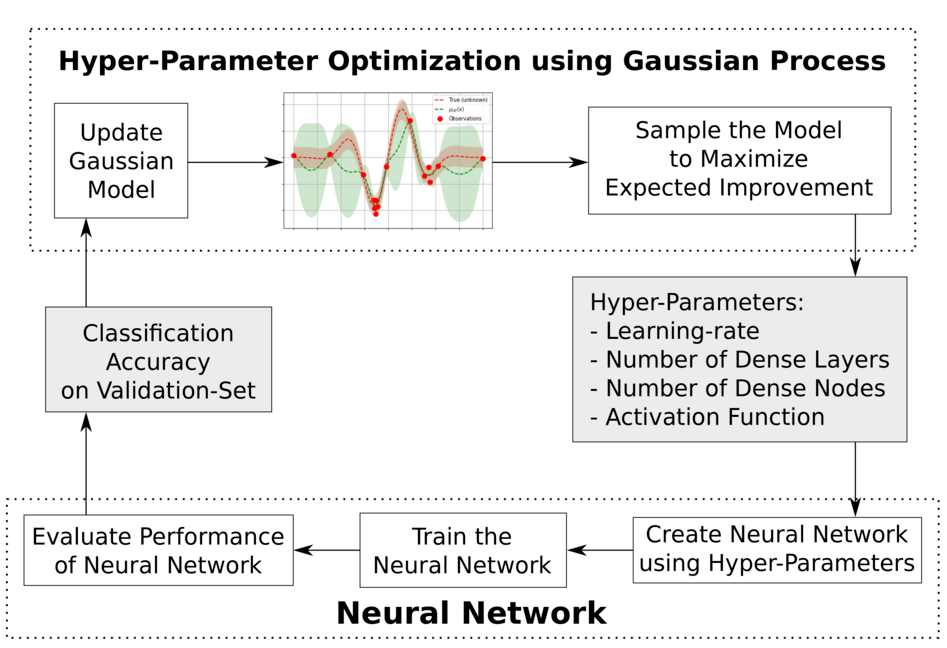

NN hyper-parameters

- spatial dropout
- dropouts 
- looak ahead steps (for optimizer)
- embedding dim

In [ ]:
dim_learning_rate = Real(low=1e-4, high=1e-1, prior='uniform', name='learning_rate')
# dim_num_dense_nodes_3 = Integer(low=256, high=512, name='num_dense_nodes_3')
# dim_activation = Categorical(categories=['relu', 'elu'], name='activation')


dim_spatial_dp = Integer(low=1, high=6, name='spatial_dp')
dim_dropout1 = Integer(low=1, high=6, name='dp1')
dim_dropout2 = Integer(low=1, high=6, name='dp2')
dim_dropout3 = Integer(low=1, high=6, name='dp3')
dim_embed_dim = Integer(low=50, high=120, name='embed_dim')
# dim_look_ahead = Integer(low=5, high=15, name='look_ahead')


dimensions = [dim_learning_rate, dim_spatial_dp, dim_dropout1, dim_dropout2, dim_dropout3, dim_embed_dim]


# set default params - make sure are within the search space
default_params = [0.001, 2, 5, 5, 5, 75] 

assert len(default_params)==len(dimensions), 'Error: check shapes!'

In [ ]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))



def build_model(learning_rate, spatial_dp, dp1, dp2, dp3, embed_dim, gru=0, seq_len=107, pred_len=68, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(spatial_dp*0.1)(reshaped)
    
    if gru==1:
        hidden = gru_layer(hidden_dim, dp1*0.1)(reshaped)
        hidden = gru_layer(hidden_dim, dp2*0.1)(hidden)
        hidden = gru_layer(hidden_dim, dp3*0.1)(hidden)
        
    elif gru==0:
        hidden = lstm_layer(hidden_dim, dp1*0.1)(reshaped)
        hidden = lstm_layer(hidden_dim, dp2*0.1)(hidden)
        hidden = lstm_layer(hidden_dim, dp3*0.1)(hidden)
        
    elif gru==3:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    elif gru==4:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    elif gru==5:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
    
    # only making predictions on the first part of each sequence
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)
    model = tf.keras.Model(inputs=inputs, outputs=out)

    # optimizers
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #     opt = tfa.optimizers.RectifiedAdam()
    #     opt = tfa.optimizers.Lookahead(opt, sync_period=6)
    
    model.compile(optimizer=opt, loss=MCRMSE, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

# Fittness Function to Optimize

This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its performance on the validation-set. The function then returns the so-called fitness value (aka. objective value), which is the negative classification accuracy on the validation-set. It is negative because skopt performs minimization instead of maximization.

The main steps that we perform are:

build and train a network with given hyper-parameters
evaluate the model performance with the validation dataset
It returns the fitness value, in our case the logloss error.
Note the function decorator @use_named_args which wraps the fitness function so that it can be called with all the parameters as a single list, for example: fitness(x=[1e-4, 3, 256, 'relu']). This is the calling-style skopt uses internally.

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness1(learning_rate, spatial_dp, dp1, dp2, dp3, embed_dim):   
    
    """
    Hyper-parameters:
    learning_rate: lr
    spatial_dp:   Spatial dropout
    dp1:          Dropout rates layer-1
    dp2:          Dropout rates layer-2
    dp3:          Dropout rates layer-3
    embed_dim:    embed dim
    """

    # Print the hyper-parameters.
    print('LR:', learning_rate)
    print('spatial dropout:', spatial_dp*0.1)
    print('dropout 1:', dp1*0.1)
    print('dropout 2:', dp2*0.1)
    print('dropout 3:', dp3*0.1)
    print('embed_dim:', embed_dim)
    print()
    
    
    
    # GRU 
    callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss'),   #,patience=15, factor=0.8
    #     get_lr_schedule(),
    #     tf.keras.callbacks.ModelCheckpoint('model_gru.h5'),
    #     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    ]

    
    # Create the neural network with these hyper-parameters.
    model = build_model(learning_rate, spatial_dp, dp1, dp2, dp3, embed_dim, gru=1)

   
    # train the model    
    hist = model.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=70, 
        callbacks=callbacks,
        verbose=0)

    print()
    print(f"Min training loss={min(hist.history['loss'])}, min validation loss={min(hist.history['val_loss'])}")
    #     print(f"Min training rmse={min(hist.history['rmse'])}, min validation rmse={min(hist.history['val_rmse'])}")

    # Get the error on the validation-set
    score = min(hist.history['val_loss'])   

    # Print the classification accuracy.
    print('-'*20)
    print(f"> Val loss (mse): {score}")
    print('-'*20)

    # Save the model if it improves on the best-found performance.
    global best_loss

    # If the classification accuracy of the saved model is improved ...
    if score < best_loss:
        
        # Save the new model & Update the error
        model.save(path_best_model)
        best_loss = score

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    gc.collect()
    
    # Clear the Keras session, to empty the TensorFlow graph 
    K.clear_session()
    
    return score

In [ ]:
# # check objective function (uncomment bellow if you like to test)

# fitness1(default_params)

# GRU - Hyper-parameter search

In [ ]:
path_best_model = 'model_gru.h5'
best_loss = 0

In [ ]:
search_result_gru = skopt.gp_minimize(func=fitness1,   
                            dimensions=dimensions,
                            acq_func='EI',    #  'gp_hedge'       
                            n_calls=N_TRIALS,
                            random_state=SEED,
                            x0=default_params)

In [ ]:
print('optimal hyper-parameters') 
print()
print(f'LR: {search_result_gru.x[0]}')
print(f'spatial dropout: {search_result_gru.x[1]}')
print(f'dropout 1: {search_result_gru.x[2]}')
print(f'dropout 2: {search_result_gru.x[3]}')
print(f'dropout 3: {search_result_gru.x[4]}')
print(f'embed dim: {search_result_gru.x[5]}')

In [ ]:
pd.DataFrame(sorted(zip(search_result_gru.func_vals, search_result_gru.x_iters)), index=np.arange(N_TRIALS), columns=['score', 'params'])

In [ ]:
%matplotlib inline
plot_convergence(search_result_gru)

In [ ]:
# create a list for plotting
dim_names = ['LR', 'spatial_dropout', 'dropout_1', 'dropout_2', 'dropout_3', 'embed_dim']

# %matplotlib inline
plot_objective(result=search_result_gru, dimensions=dim_names);

# LSTM - Hyper-parameter search

In [ ]:
path_best_model = 'model_lstm.h5'
best_loss = 0

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness2(learning_rate, spatial_dp, dp1, dp2, dp3, embed_dim):   
    
    """
    Hyper-parameters:
    learning_rate: LR
    spatial_dp:   Spatial dropout
    dp1:          Dropout rates layer-1
    dp2:          Dropout rates layer-2
    dp3:          Dropout rates layer-3
    embed_dim:    embed dim
    """

    # Print the hyper-parameters.
    print('learning_rate', learning_rate)
    print('spatial dropout:', spatial_dp*0.1)
    print('dropout 1:', dp1*0.1)
    print('dropout 2:', dp2*0.1)
    print('dropout 3:', dp3*0.1)
    print('embed_dim:', embed_dim)
    print()
    
    
    # GRU 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss')]

    
    # Create the neural network with these hyper-parameters.
    model = build_model(learning_rate, spatial_dp, dp1, dp2, dp3, embed_dim, gru=0)

   
    # train the model    
    hist = model.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=70, 
        callbacks=callbacks,
        verbose=0)

    print()
    print(f"Min training loss={min(hist.history['loss'])}, min validation loss={min(hist.history['val_loss'])}")
    #     print(f"Min training rmse={min(hist.history['rmse'])}, min validation rmse={min(hist.history['val_rmse'])}")
    

    # Get the error on the validation-set
    score = min(hist.history['val_loss'])   

    # Print the classification accuracy.
    print('-'*20)
    print(f"> Val loss (mse): {score}")
    print('-'*20)

    # Save the model if it improves on the best-found performance.
    global best_loss

    # If the classification accuracy of the saved model is improved ...
    if score < best_loss:
        
        # Save the new model & Update the error
        model.save(path_best_model)
        best_loss = score

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    gc.collect()
    
    # Clear the Keras session, to empty the TensorFlow graph 
    K.clear_session()
    
    return score

In [ ]:
search_result_lstm = skopt.gp_minimize(func=fitness2,   
                            dimensions=dimensions,
                            acq_func='EI',    #  'gp_hedge'       
                            n_calls=N_TRIALS,
                            random_state=SEED,
                            x0=default_params)

In [ ]:
print('optimal hyper-parameters') 
print()
print(f'LR: {search_result_lstm.x[0]}')
print(f'spatial dropout: {search_result_lstm.x[1]}')
print(f'dropout 1: {search_result_lstm.x[2]}')
print(f'dropout 2: {search_result_lstm.x[3]}')
print(f'dropout 3: {search_result_lstm.x[4]}')
print(f'embed dim: {search_result_lstm.x[5]}')

In [ ]:
pd.DataFrame(sorted(zip(search_result_lstm.func_vals, search_result_lstm.x_iters)), index=np.arange(N_TRIALS), columns=['score', 'params'])

In [ ]:
%matplotlib inline
plot_convergence(search_result_lstm)

In [ ]:
# %matplotlib inline
plot_objective(result=search_result_lstm, dimensions=dim_names);

# Reproduce models with best hyper-parameters

In [ ]:
# create models with best hyperparams

best_model_gru = build_model(*search_result_gru.x, gru=1)
best_model_gru.summary()

best_model_lstm = build_model(*search_result_lstm.x, gru=0)
best_model_lstm.summary()

# Work in progress! 


# Credits

- towards-data-science article
- skopt documentation and examples